In [24]:
#import the libraries
import psycopg2
import geopandas as gpd
from shapely.geometry import Point, Polygon
#import contextily as cx
#import osmnx as ox
import shapely

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [2]:
# PostgreSQL database connection details
db_params = {
    "host": "::1",
    "database": "osm",
    "user": "postgres",
    "password": 
}

In [3]:
#define the query
conn = psycopg2.connect(**db_params)
query_table2 = """
    select * from amenity_counts  
"""

In [4]:
#generate the table from the query
amenity_count = gpd.read_postgis(query_table2, conn, geom_col="point_id")
#observe the dataset
amenity_count.head()
conn.close()

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\geopandas\io\sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [6]:
amenity_count_model=amenity_count.copy()
amenity_count_model["food_and_bev"]=amenity_count['amenity_count_restaurant']+amenity_count['amenity_count_cafe']+amenity_count['amenity_count_fast_food']+amenity_count['amenity_count_pub']+amenity_count['amenity_count_bar']+ amenity_count['amenity_count_ice_cream']
amenity_count_model = amenity_count_model.drop(columns=[ 'amenity_count_restaurant', 'amenity_count_cafe',
       'amenity_count_fast_food', 'amenity_count_pub', 'amenity_count_bar', 'amenity_count_ice_cream'])

In [11]:
amenity_count_model["count"] = amenity_count_model.iloc[:,1:].sum(axis=1)

In [13]:
amenity_count_model = amenity_count_model[amenity_count_model["count"]>0]

In [15]:
amenity_count_model.describe()

,amenity_count_bicycle_parking,amenity_count_parking_entrance,amenity_count_atm,amenity_count_charging_station,amenity_count_pharmacy,amenity_count_parking,amenity_count_taxi,amenity_count_bank,amenity_count_post_office,amenity_count_place_of_worship,...,building_count_supermarket,building_count_container,building_count_bridge,building_count_electricity,building_count_farm_auxiliary,building_count_cabin,building_count_silo,building_count_fire_station,food_and_bev,count
count,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,...,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000
mean,6.134869,0.678039,0.359662,0.290091,0.251014,0.187926,0.127571,0.114425,0.067489,0.065443,...,0.048367,0.040544,0.038045,0.038299,0.031218,0.030259,0.026257,0.027669,1.932529,108.606457
std,14.614518,1.786352,1.227225,0.820825,0.655862,0.642800,0.416426,0.522322,0.274843,0.301308,...,0.272339,0.384642,0.278365,0.269874,0.366661,0.528157,0.436711,0.243032,5.420978,108.981334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.000000
75%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,161.000000
max,167.000000,27.000000,18.000000,14.000000,7.000000,12.000000,8.000000,8.000000,4.000000,6.000000,...,8.000000,10.000000,9.000000,8.000000,13.000000,20.000000,20.000000,6.000000,105.000000,825.000000


In [87]:
amenity_count_model.to_csv("amenity_count_model.csv")

In [16]:
#divide the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(amenity_count_model.drop(columns=["point_id","food_and_bev", "count"]), amenity_count_model["food_and_bev"], test_size = 0.3, random_state = 101)

In [17]:
regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 114)
regr.fit(X_train, y_train)

predictions = regr.predict(X_test)

r2 = r2_score(y_test, predictions)
r2

0.871262375053969

In [18]:
characteristics = X_train.columns
# Get the variables importances, sort them, and print the result
importances = list(regr.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: amenity_count_atm    Importance: 0.68
Variable: amenity_count_pharmacy Importance: 0.05
Variable: building_count_apartments Importance: 0.05
Variable: building_count_residential Importance: 0.04
Variable: amenity_count_bicycle_parking Importance: 0.01
Variable: amenity_count_charging_station Importance: 0.01
Variable: amenity_count_bank   Importance: 0.01
Variable: amenity_count_arts_centre Importance: 0.01
Variable: amenity_count_marketplace Importance: 0.01
Variable: railway_count_subway_entrance Importance: 0.01
Variable: building_count_commercial Importance: 0.01
Variable: building_count_roof  Importance: 0.01
Variable: building_count_retail Importance: 0.01
Variable: building_count_office Importance: 0.01
Variable: amenity_count_parking_entrance Importance: 0.0
Variable: amenity_count_parking Importance: 0.0
Variable: amenity_count_taxi   Importance: 0.0
Variable: amenity_count_post_office Importance: 0.0
Variable: amenity_count_place_of_worship Importance: 0.0
Variable:

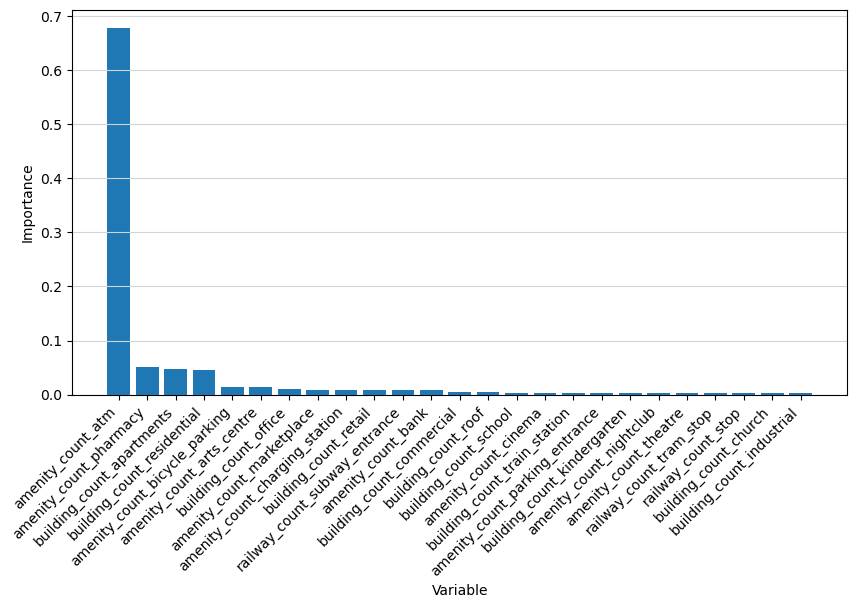

In [19]:
# Visualize the variables main importances
importances, characteristics = zip(*sorted(zip(importances, characteristics),reverse=True))
plt.figure(figsize=(10,5))
plt.bar(characteristics[:25], importances[:25], orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.xticks(rotation=45, ha='right')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()

In [20]:
xgbr = XGBRegressor(n_estimators = 100, max_depth = 10, random_state = 114)
xgbr.fit(X_train, y_train)

predictions = xgbr.predict(X_test)

r2 = r2_score(y_test, predictions)
r2

0.9113504986329054

In [22]:
explainer = shap.Explainer(xgbr, X_train)
shap_values = explainer(X_train)

[21:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 38375/38656 [01:59<00:00]        

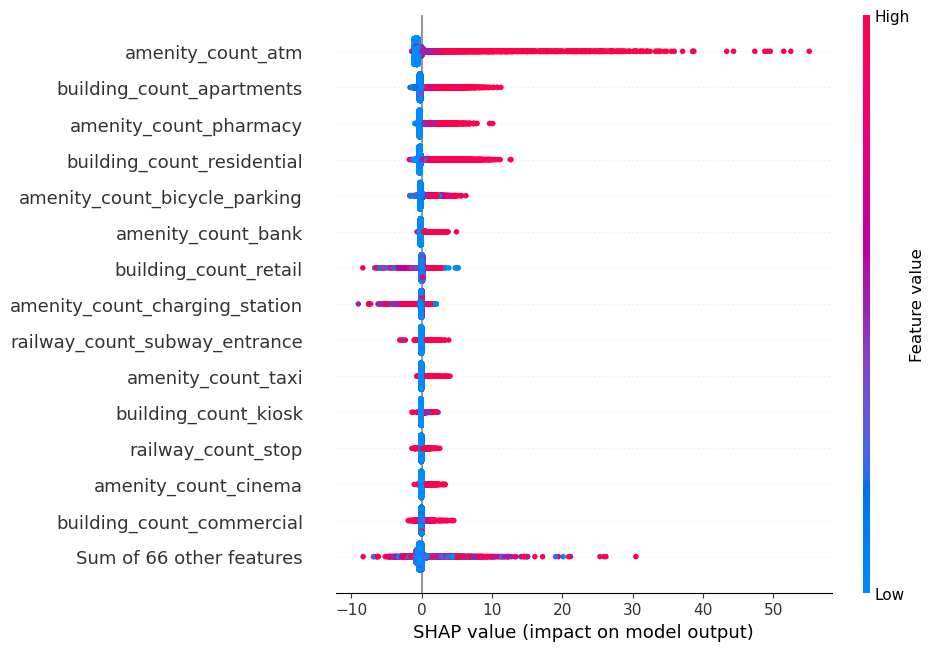

In [26]:
shap.plots.beeswarm(shap_values, max_display=15)

*Considering the correlation between atms and out y variable, we will remove it from the dataset*

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(amenity_count_model.drop(columns=["point_id","food_and_bev", "count", "amenity_count_atm"]), amenity_count_model["food_and_bev"], test_size = 0.3, random_state = 101)

In [28]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01, .03, .05, ], #so called `eta` value
              'max_depth': [3, 4, 5, 10],
              'min_child_weight': [2, 3, 4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200, 300, 400]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train2,
         y_train2)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[22:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
[22:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [3, 4, 5, 10],
                         'min_child_weight': [2, 3, 4],
                         'n_estimators': [200, 300, 400], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [29]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8837603426341305
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 400, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [30]:
#divide the test dataset in test and validation
X_test3, X_val,  y_test3, y_val = train_test_split(X_test2, y_test2, test_size = 0.5, random_state = 101)

In [35]:
scaler = MinMaxScaler()
X_train_nor =  scaler.fit_transform(X_train2)
X_test_nor =  scaler.fit_transform(X_test3)
X_val_nor =  scaler.fit_transform(X_val)

In [36]:
scaler = StandardScaler()
X_train_nor =  scaler.fit_transform(X_train2)
X_test_nor =  scaler.transform(X_test3)
X_val_nor =  scaler.transform(X_val)

In [41]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train2.shape[0]
data_columns_number = X_train2.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train2, y_train2, epochs=40, batch_size=50, verbose=0, validation_data=(X_test3, y_test3))

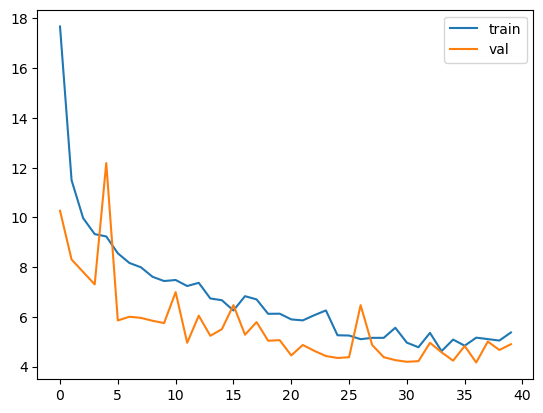

In [42]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [43]:
predictions = model.predict(X_test3)#.round(0)
r2 = r2_score(y_test3, predictions)
r2

259/259 [==============================] - 0s 1ms/step


0.8375330800592241

In [44]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train2.shape[0]
data_columns_number = X_train2.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train_nor, y_train2, epochs=40, batch_size=50, verbose=0, validation_data=(X_test_nor, y_test3))

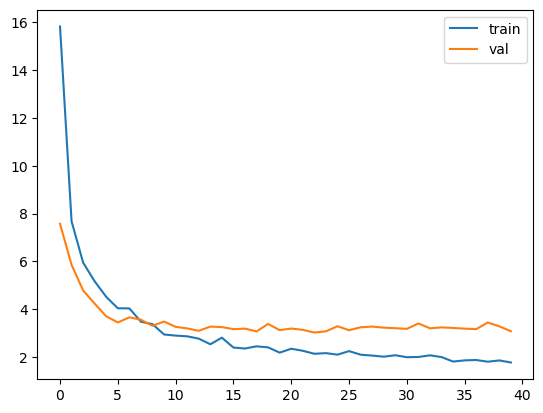

In [45]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [46]:
predictions = model.predict(X_test_nor)#.round(0)
r2 = r2_score(y_test3, predictions)
r2

259/259 [==============================] - 0s 1ms/step


0.8980718638982641

In [47]:
model.save('model1.keras')

In [48]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train2.shape[0]
data_columns_number = X_train2.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
layer3 = Dense(number_hidden_units1, activation = "relu")(dropout2)
dropout3 = Dropout(0.2)(layer3)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout3)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train2, y_train2, epochs=40, batch_size=50, verbose=0, validation_data=(X_test3, y_test3))


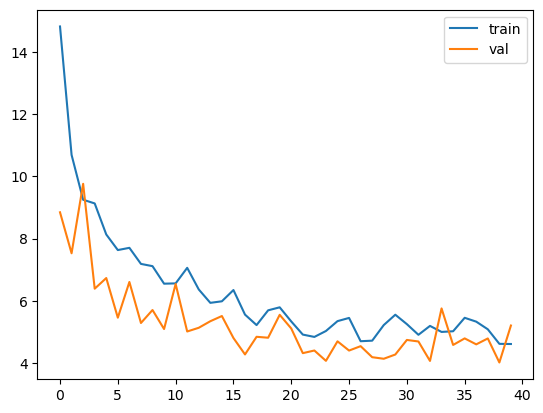

In [49]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [50]:
predictions = model.predict(X_test3)#.round(0)
r2 = r2_score(y_test3, predictions)
r2

259/259 [==============================] - 0s 865us/step


0.8274964831993301

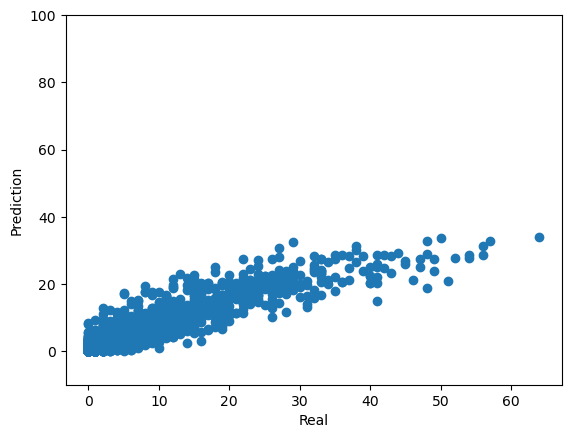

In [51]:
plt.scatter(y_test3, predictions)
plt.ylim([-10,100])
plt.xlabel("Real")
plt.ylabel("Prediction")
plt.show()

In [82]:
hidden_size = 100
number_hidden_units1 = 256
data_rows_number = X_train2.shape[0]
data_columns_number = X_train2.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.4)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.3)(layer2)  # Add dropout layer with 0.2 dropout rate
layer3 = Dense(number_hidden_units1, activation = "relu")(dropout2)
dropout3 = Dropout(0.1)(layer3)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout3)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train_nor, y_train2, epochs=60, batch_size=256, verbose=0, validation_data=(X_test_nor, y_test3))


(1.5, 5.0)

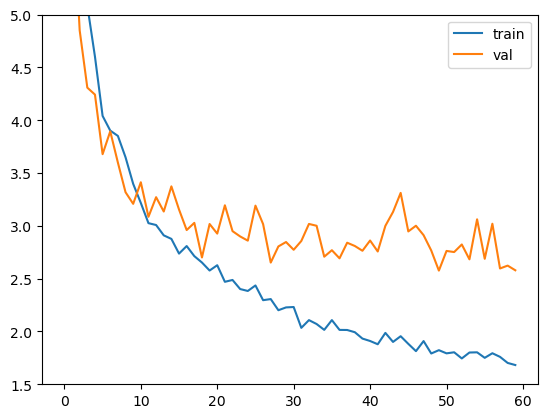

In [83]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()
plt.ylim([1.5,5])

In [84]:
predictions = model.predict(X_test_nor)#.round(0)
r2 = r2_score(y_test3, predictions)
r2

259/259 [==============================] - 0s 1ms/step


0.9144988694548146

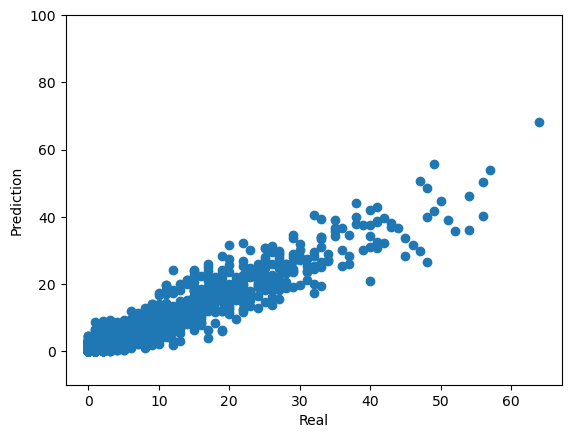

In [85]:
plt.scatter(y_test3, predictions)
plt.ylim([-10,100])
plt.xlabel("Real")
plt.ylabel("Prediction")
plt.show()

In [86]:
model.save('model2.keras')